## From Your Favorite Book to Your Favorite Podcast
Insight Fellowship・Data Demonstration<br/>
Carl Huang ( http://carlhuang.com )<br/>
Nov 9, 2020


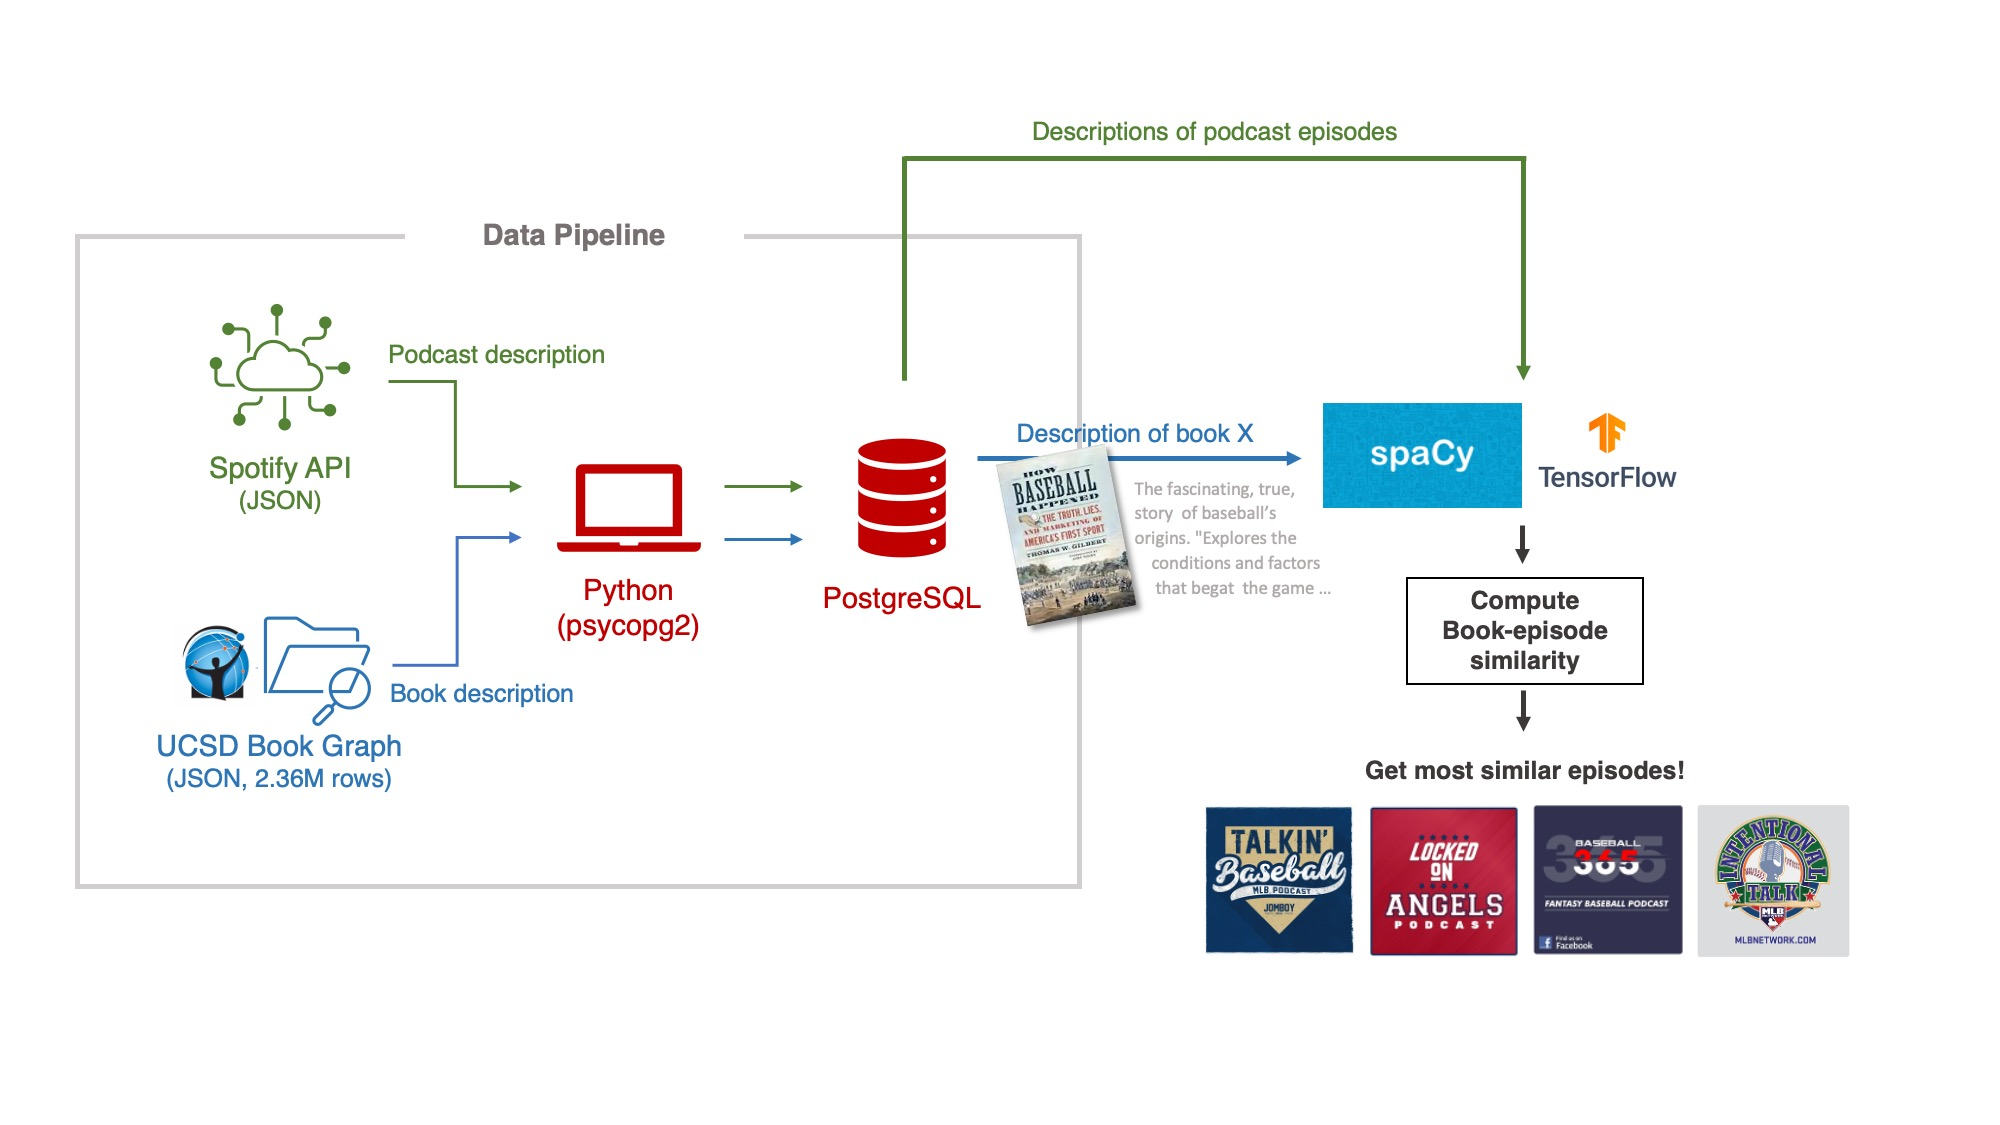

In [11]:
from IPython.display import Image
Image(filename='architecture.jpg')

In [12]:
import re
import time
import json
import configparser
import psycopg2
import random
import logging
import string
import spacy
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth

import pandas as pd
import seaborn as sns
import tensorflow as tf
from langdetect import detect
from datetime import datetime

sns.set_theme(style="darkgrid")
pd.options.mode.chained_assignment = None
logging.getLogger('tensorflow').disabled = True

## 1. Data Pipeline
### 1.1 Using class to handle ETL
Since both the `Spotify API` and `UCSD Book Graph` pipelines involves (1) extracting JSON data, (2) transform data, and (3) loading data into PostgreSQL, I will build a general class to reduce redundant codes:

In [13]:
class etl_handler(object):
    "A class that loads a JSON file, transform data, and insert data into PostgreSQL tables"
    def __init__(self):
        self.config = '/Users/Carl/_data Science/_project/book to podcast/database.ini'
        self.data = None
    
    def psql_insert(self):
        return self.insert_table

    # Loading functions
    def load_json(self, json_file: str, max_line = None):
        """
        Takes a JSON file path and maximum lines to be loaded.
        Saves loaded data in self.data
        """
        data = []
        count = 0
        with open(json_file, 'r') as f:
            for line in f:
                dict_ = json.loads(line)
                data.append(dict_)
                count += 1
                if max_line:
                    if count == max_line:
                        break
            self.data = pd.DataFrame(data)

    # Data wrangling/cleaning functions
    def get_data(self, rows: int = None, random_draw: bool = False, seed: int = None):
        """
        Takes the number of rows to be displayed and whether a randome sample should be drawn.
        Returns a pandas DataFrame with specifications above.
        """
        if self.data is not None:
            if not rows:
                # If 'row' is not given, the all rows from self.data will be read.
                rows = self.data.shape[0]
            if random_draw:
                if seed:
                    return self.data.sample(n=rows, random_state=seed)
            else:
                return self.data[:rows]
        else:
            print("Error. Data not loaded. User load_json() to load data first.")
    
    def select_columns(self, cols: list):
        """Limit the columns of self.data to the columne list provided"""
        self.data = self.data[cols]
    
    def add_column(self, col_name, content):
        """Add a new column to self.data with content provided in *content* """
        self.data[col_name] = content
    
    def filter_value(self, column, value, how = None):
        """Only keeps examples that match the value conditions specified in argument"""
        if how == '==':
            self.data = self.data.loc[self.data[column] == value]

        if how == '>=':
            self.data = self.data.loc[self.data[column] >= value]

        if how == '>':
            self.data = self.data.loc[self.data[column] > value]

        if how == '<=':
            self.data = self.data.loc[self.data[column] <= value]

        if how == '<':
            self.data = self.data.loc[self.data[column] < value]
        
        self.data = self.data.reset_index(drop=True)
        return None
        
    def column_function(self, cols: list, func):
        """Apply function *func* to the specified column in self.data"""
        for col in cols:
            new_col = self.data[col].map(func)
            self.data.loc[:, col] = new_col
        return None
    
    def drop_na(self):
        self.data = self.data.dropna()
        self.data = self.data.reset_index(drop=True)
        return None
    
    # PSQL helper functions
    def psql_connect(self):
        "Given a confige file (config.ini), this function locates information PostgreSQL "
        config = configparser.ConfigParser()
        config.read(self.config)
        connection = psycopg2.connect(
            host = config['postgres']['host'],
            database = config['postgres']['database'],
            user = config['postgres']['user'],
            password = config['postgres']['password']
            )
        cursor = connection.cursor()
        return connection, cursor

### 1.1.1 Loading Book Data from UCSD Book Graph

In [14]:
class bookgraph_etl(etl_handler):
    def __init__(self):
        super().__init__()
        self.create_table = ("""CREATE TABLE IF NOT EXISTS book(
                                book_id bigint PRIMARY KEY,
                                year smallint NOT NULL,
                                rating_counts int NOT NULL,
                                title varchar(250) NOT NULL UNIQUE,
                                description varchar(500),
                                authors varchar(250),
                                language varchar(20))""")
        
        self.insert_table = ("""INSERT INTO book 
                               (book_id, year, rating_counts, title, description, authors, language)
                               VALUES (%s, %s, %s, %s, %s, %s, %s)
                               ON CONFLICT DO NOTHING""")
        
    def psql_create(self):
        return self.create_table

    def psql_insert(self):
        return self.insert_table

In [15]:
bookgraph = bookgraph_etl()
bookgraph.load_json('/Users/Carl/_data Science/_data/UCSD Bookgraph/goodreads_books.json', max_line = 1_000)

In [16]:
bookgraph.get_data(rows=5)

,isbn,text_reviews_count,series,country_code,language_code,popular_shelves,asin,is_ebook,average_rating,kindle_asin,...,publication_month,edition_information,publication_year,url,image_url,book_id,ratings_count,work_id,title,title_without_series
0,0312853122,1,[],US,,"[{'count': '3', 'name': 'to-read'}, {'count': ...",,false,4.00,,...,9,,1984,https://www.goodreads.com/book/show/5333265-w-...,https://images.gr-assets.com/books/1310220028m...,5333265,3,5400751,W.C. Fields: A Life on Film,W.C. Fields: A Life on Film
1,0743509986,6,[],US,,"[{'count': '2634', 'name': 'to-read'}, {'count...",,false,3.23,B000FC0PBC,...,10,Abridged,2001,https://www.goodreads.com/book/show/1333909.Go...,https://s.gr-assets.com/assets/nophoto/book/11...,1333909,10,1323437,Good Harbor,Good Harbor
2,,7,[189911],US,eng,"[{'count': '58', 'name': 'to-read'}, {'count':...",B00071IKUY,false,4.03,,...,,Book Club Edition,1987,https://www.goodreads.com/book/show/7327624-th...,https://images.gr-assets.com/books/1304100136m...,7327624,140,8948723,"The Unschooled Wizard (Sun Wolf and Starhawk, ...","The Unschooled Wizard (Sun Wolf and Starhawk, ..."
3,0743294297,3282,[],US,eng,"[{'count': '7615', 'name': 'to-read'}, {'count...",,false,3.49,B002ENBLOK,...,7,,2009,https://www.goodreads.com/book/show/6066819-be...,https://s.gr-assets.com/assets/nophoto/book/11...,6066819,51184,6243154,Best Friends Forever,Best Friends Forever
4,0850308712,5,[],US,,"[{'count': '32', 'name': 'to-read'}, {'count':...",,false,3.40,,...,,,,https://www.goodreads.com/book/show/287140.Run...,https://images.gr-assets.com/books/1413219371m...,287140,15,278577,Runic Astrology: Starcraft and Timekeeping in ...,Runic Astrology: Starcraft and Timekeeping in ...


### 1.1.2 Select Relevant Columns, Set Data Type
The original `bookgraph` data has 29 columns.

In [17]:
bookgraph.get_data().columns

Index(['isbn', 'text_reviews_count', 'series', 'country_code', 'language_code',
       'popular_shelves', 'asin', 'is_ebook', 'average_rating', 'kindle_asin',
       'similar_books', 'description', 'format', 'link', 'authors',
       'publisher', 'num_pages', 'publication_day', 'isbn13',
       'publication_month', 'edition_information', 'publication_year', 'url',
       'image_url', 'book_id', 'ratings_count', 'work_id', 'title',
       'title_without_series'],
      dtype='object')

To provide users recommendation and relevant information, I trim down the original data into these columns below, and separate them based on "numeric" and "categorical":

In [18]:
int_cols = ['book_id', 'publication_year', 'ratings_count']
str_cols = ['title', 'description', 'authors']
bookgraph.select_columns(int_cols+str_cols)

In [19]:
def int_transform(text):
    return int(text) if text != '' else None

def str_transform(text):
    return text if len(text) != 0 else None

bookgraph.column_function(int_cols, int_transform)
bookgraph.column_function(str_cols, str_transform)

In [20]:
bookgraph.get_data()

,book_id,publication_year,ratings_count,title,description,authors
0,5333265,1984.0,3,W.C. Fields: A Life on Film,None,"[{'author_id': '604031', 'role': ''}]"
1,1333909,2001.0,10,Good Harbor,"Anita Diamant's international bestseller ""The ...","[{'author_id': '626222', 'role': ''}]"
2,7327624,1987.0,140,"The Unschooled Wizard (Sun Wolf and Starhawk, ...",Omnibus book club edition containing the Ladie...,"[{'author_id': '10333', 'role': ''}]"
3,6066819,2009.0,51184,Best Friends Forever,Addie Downs and Valerie Adler were eight when ...,"[{'author_id': '9212', 'role': ''}]"
4,287140,NaN,15,Runic Astrology: Starcraft and Timekeeping in ...,None,"[{'author_id': '149918', 'role': ''}]"
...,...,...,...,...,...,...
995,16034992,2005.0,52,Το άλικο γράμμα,"Bostone, mesa tou 17ou aiona. Mia neare gunaik...","[{'author_id': '7799', 'role': ''}, {'author_i..."
996,10290982,NaN,68,Clockwork Fairies,Desiree feels the most at home with her clockw...,"[{'author_id': '1014253', 'role': ''}]"
997,7561212,NaN,9,Speed Shrinking,"""Proust had a cookie. Susan Shapiro has a cupc...","[{'author_id': '133658', 'role': ''}]"
998,10290984,2010.0,131,101 Hantu Nusantara,Konon hantu itu berangkat dari budaya takut ya...,"[{'author_id': '4599042', 'role': ''}]"


### 1.1.3 Dealing with NaNs and Nones

In [21]:
bookgraph.drop_na()

### 1.1.4 Increase `authors` column usability

In [22]:
# Global variable so the same author_data will not be loaded multiple times
global author_data

# The same etl_handler() can do most of the work:
author_data = etl_handler()
author_data.load_json('/Users/Carl/_data Science/_data/UCSD Bookgraph/goodreads_book_authors.json')
author_data.select_columns(['author_id','name'])
author_data = author_data.get_data().set_index('author_id')

def get_author_name(author_id: str):
    "Takes a Bookgraph author_id and returns the author's actual name"
    # [0] selects the text of an author's name without the entire pd.Series    
    return author_data.loc[author_id][0]

def get_authors(authors: list, max_len = 250):
    "Takes a list of author dictionaries, find main author, and return a list of authors in text"
    temp = list()
    for author in authors:
        # In Bookgraph, default author role is ''. Only contributors/illustrators/translators are specified
        if author.get('role') == '':
            author_id = author.get('author_id')
            author_name = get_author_name(author_id)
            temp.append(author_name)
    return ', '.join(temp)[:max_len]


In [23]:
author_data.head()

,name
author_id,
604031,Ronald J. Fields
626222,Anita Diamant
10333,Barbara Hambly
9212,Jennifer Weiner
149918,Nigel Pennick


In [24]:
bookgraph.column_function(['authors'], get_authors)
bookgraph.get_data()

,book_id,publication_year,ratings_count,title,description,authors
0,1333909,2001.0,10,Good Harbor,"Anita Diamant's international bestseller ""The ...",Anita Diamant
1,7327624,1987.0,140,"The Unschooled Wizard (Sun Wolf and Starhawk, ...",Omnibus book club edition containing the Ladie...,Barbara Hambly
2,6066819,2009.0,51184,Best Friends Forever,Addie Downs and Valerie Adler were eight when ...,Jennifer Weiner
3,287141,2006.0,46,The Aeneid for Boys and Girls,"Relates in vigorous prose the tale of Aeneas, ...",Alfred J. Church
4,6066812,2009.0,98,All's Fairy in Love and War (Avalon: Web of Ma...,"To Kara's astonishment, she discovers that a p...",Rachel Roberts
...,...,...,...,...,...,...
648,10852766,1977.0,8,Het geslacht Wiarda,Bevat:\n- Noorderzon\n- Stiefmoeder aarde\n- H...,Theun de Vries
649,15843133,2013.0,160,Math on Trial: How Numbers Get Used and Abused...,"In the wrong hands, math can be deadly. Even t...","Leila Schneps, Coralie Colmez"
650,17609729,2013.0,4761,My Everything (The Beaumont Series #1.5),"When Nick Ashford lost his friend, Mason, he d...",Heidi McLaughlin
651,16034992,2005.0,52,Το άλικο γράμμα,"Bostone, mesa tou 17ou aiona. Mia neare gunaik...",Nathaniel Hawthorne


### 1.1.5 Clean Up Title and Text Description

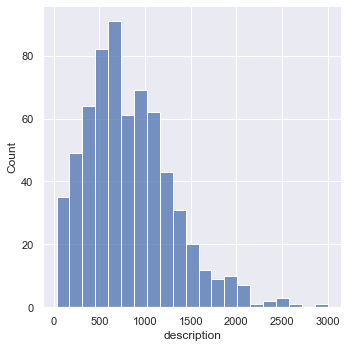

In [25]:
sns.displot(bookgraph.get_data(), x=bookgraph.get_data().description.transform(lambda x: len(x)))

#### Unusually short descriptions
A quick glance reveals that descriptions with a length shorter than 50 is rather noisy without much information that might be useful to set up a recommendation system. So for this test I decide to remove examples with descriptions like these later on.

In [26]:
print(bookgraph.get_data().loc[bookgraph.get_data().description.map(len)< 50]['description'].to_list())

['Translation of: Prestuplenie i nakazanie.', 'Playing time: 12 hours 55 mins.']


#### Unusually long descriptions
By contrast, very long descriptions are long, but they

In [27]:
bookgraph.get_data().description.map(len).max()

3000

In [28]:
long_text = bookgraph.get_data().loc[bookgraph.get_data().description.map(len)==6350]['description'].to_list()
long_text

[]

In [29]:
def standardize_description(text, max_len=500, min_len = 50):
    text = text.replace('\n',' ')
    text = text.replace("\'",'')
    # Remove web urls    
    text = re.sub('http[s]*://\S+', '', text)
    # Remove phone number
    text = re.sub('[0-9]{4}[0-9]+', '', text)
    # Remove email
    text = re.sub('\S+@\S+', '', text)
    # Remove hashtags
    text = re.sub('#\S+', '', text)
    # Remove repeating space
    text = re.sub('\s\s+', ' ', text)
    text = text.strip()
    
    # rsplit(maxsplit=1)[0] takes away only the right-most part of text separated by '. '
    text = text[:max_len].rsplit('. ', maxsplit=1)[0]
    if len(text) < min_len:
        return None
    else:
        return text
    
def standardize_title(x):
    return standardize_description(x, max_len=250, min_len = 1)

In [30]:
bookgraph.column_function(['description'], standardize_description)
bookgraph.column_function(['title'], standardize_title)
bookgraph.drop_na()

In [31]:
data = bookgraph.get_data().copy()
data

,book_id,publication_year,ratings_count,title,description,authors
0,1333909,2001.0,10,Good Harbor,"Anita Diamants international bestseller ""The R...",Anita Diamant
1,7327624,1987.0,140,"The Unschooled Wizard (Sun Wolf and Starhawk,",Omnibus book club edition containing the Ladie...,Barbara Hambly
2,6066819,2009.0,51184,Best Friends Forever,Addie Downs and Valerie Adler were eight when ...,Jennifer Weiner
3,287141,2006.0,46,The Aeneid for Boys and Girls,"Relates in vigorous prose the tale of Aeneas, ...",Alfred J. Church
4,6066812,2009.0,98,"Alls Fairy in Love and War (Avalon: Web of Magic,","To Karas astonishment, she discovers that a po...",Rachel Roberts
...,...,...,...,...,...,...
640,10852766,1977.0,8,Het geslacht Wiarda,Bevat: - Noorderzon - Stiefmoeder aarde - Het ...,Theun de Vries
641,15843133,2013.0,160,Math on Trial: How Numbers Get Used and Abused...,"In the wrong hands, math can be deadly. Even t...","Leila Schneps, Coralie Colmez"
642,17609729,2013.0,4761,My Everything (The Beaumont Series,"When Nick Ashford lost his friend, Mason, he d...",Heidi McLaughlin
643,16034992,2005.0,52,Το άλικο γράμμα,"Bostone, mesa tou 17ou aiona. Mia neare gunaik...",Nathaniel Hawthorne


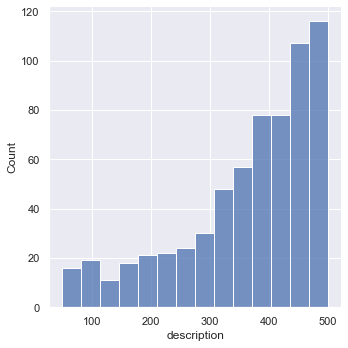

In [32]:
sns.displot(data, x = data.description.map(lambda x: len(x)))

Language

In [33]:
now = datetime.now()
language_col = ['other' for i in range(len(bookgraph.get_data().description))]

for i in range(len(bookgraph.get_data().description)):
    try: 
        lang = detect(bookgraph.get_data().description[i])
        language_col[i] = lang
    except:
        continue

# Language detection is rather time-consuming and computationally expensive
print(datetime.now() - now)
bookgraph.add_column('language', language_col)

0:00:02.846804


<AxesSubplot:>

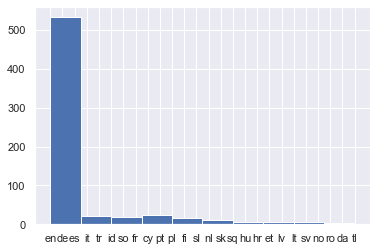

In [34]:
bookgraph.get_data().language.hist()

In [35]:
bookgraph.filter_value(column = 'language', value = 'en', how = '==')

### 1.1.6 Narrowing Years

In [36]:
bookgraph.filter_value(column='publication_year', value=1980, how='>=')
bookgraph.filter_value(column='publication_year', value=2020, how='<=')

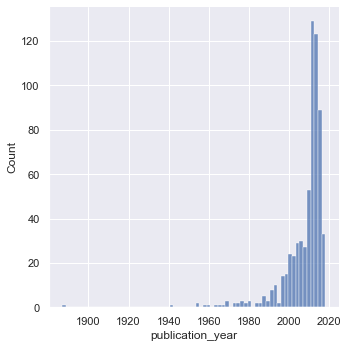

In [37]:
sns.displot(data, x='publication_year')

### 1.1.7 Insert into PostgreSQL

In [38]:
conn, cur = bookgraph.psql_connect()

In [39]:
cur.execute(bookgraph.psql_create())
conn.commit()

In [40]:
for i, row in bookgraph.get_data().iterrows():
    cur.execute(bookgraph.psql_insert(), row)
    conn.commit()

In [41]:
conn.close()

In [42]:
%load_ext sql
%sql postgresql://carl@localhost:5432/book_podcast
%sql SELECT * FROM book LIMIT 5;   

 * postgresql://carl@localhost:5432/book_podcast
5 rows affected.


book_id,year,rating_counts,title,description,authors,language
1333909,2001,10,Good Harbor,"Anita Diamants international bestseller ""The Red Tent"" brilliantly re-created the ancient world of womanhood. Diamant brings her remarkable storytelling skills to ""Good Harbor"" -- offering insight to the precarious balance of marriage and career, motherhood and friendship in the world of modern women. The seaside town of Gloucester, Massachusetts is a place where the smell of the ocean lingers in the air and the rocky coast glistens in the Atlantic sunshine",Anita Diamant,en
7327624,1987,140,"The Unschooled Wizard (Sun Wolf and Starhawk, #1-2)",Omnibus book club edition containing the Ladies of Madrigyn and the Witches of Wenshar.,Barbara Hambly,en
6066819,2009,51184,Best Friends Forever,"Addie Downs and Valerie Adler were eight when they first met and decided to be best friends forever. But, in the wake of tragedy and betrayal during their teenage years, everything changed. Val went on to fame and fortune. Addie stayed behind in their small Midwestern town. Destiny, however, had more in store for these two",Jennifer Weiner,en
287141,2006,46,The Aeneid for Boys and Girls,"Relates in vigorous prose the tale of Aeneas, the legendary ancestor of Romulus, who escaped from the burning city of Troy and wandered the Mediterranean for years before settling in Italy",Alfred J. Church,en
6066812,2009,98,"All's Fairy in Love and War (Avalon: Web of Magic, #8)","To Karas astonishment, she discovers that a portal has opened in her bedroom closet and two goblins have fallen through! They refuse to return to the fairy realms and be drafted for an impending war. In an attempt to roust the pesky creatures, Kara falls through the portal, smack into the middle of a huge war. Kara meets Queen Selinda, who appoints Kara as a Fairy Princess and assigns her an impossible task: to put an end to the war using her diplomatic skills",Rachel Roberts,en


### 1.2.1. Loading Podcasts

In [48]:
class episode_etl(bookgraph_etl):

    def __init__(self):
        super().__init__()
        self.create_table = ("""CREATE TABLE IF NOT EXISTS episode(
                                episode_id text PRIMARY KEY NOT NULL,
                                name text NOT NULL,
                                external_url text NOT NULL, 
                                image_url text NOT NULL, 
                                language text NOT NULL,
                                release_date date NOT NULL,
                                description varchar(500) NOT NULL
                                )""")
        
        self.insert_table = ("""INSERT INTO episode 
                        (episode_id, name, release_date, description, external_url, image_url, language)
                        VALUES (%s, %s, %s, %s, %s, %s, %s)
                        ON CONFLICT (episode_id) DO NOTHING""")

            
    def spotify_connect(self):
        "Build connection with the Spotify API"
        
        config = configparser.ConfigParser()
        config.read(self.config)
        scope = "user-library-read"
        
        sp = spotipy.Spotify(auth_manager = SpotifyOAuth(scope=scope, 
                                                         client_id = config['spotify']['client_id'], 
                                                         client_secret = config['spotify']['client_secret'],
                                                         redirect_uri='http://nuthatch.carlhuang.com'))
        self.spotify_connection = sp
        return "connection established"
    
    def parse_data(self, results):
        pd_temp = list()
        cols = ['id', 'name','release_date','description','external_urls', 'images']        
        for item in results['episodes']['items']:
            d = {}
            try:
                for col in cols:
                    d[col] = item[col]
                d['external_urls'] = item['external_urls']['spotify']
                d['images'] = item['images'][-1]['url']
                # d['languages'] = item['languages'][0]
                pd_temp.append(d)

            except:
                continue
        return pd_temp
    
    def load_show(self, key='.+', target_rows = 2000, type = 'Show', random_search = False):
        "Type can either be show (podcast) or episode"
        # Spotify API limits 50 rows of query per second
        sp = self.spotify_connection
        count = 0
        offset = 0
        loaded_data = []
        
        def legal_query(key):
            temp = []
            for i in range(0, target_rows, 50):
                if offset % 100 == 0:
                    print('Retrieving rows {}/{} with key {}'.format(i, target_rows, key))
                    results = sp.search(key, market = 'US', limit = 50, offset = i, type = type)
                    temp += self.parse_data(results)
                    time.sleep(1)
            return temp
        
        if not random_search:
            loaded_data += legal_query(key)
            
        else:
            alph = list(string.ascii_lowercase) + ['.+', 'baseball']
            while len(alph) > 0:
                rdn_key = alph.pop(alph.index(random.choice(alph)))
                new_rows = legal_query(rdn_key)
                count += len(new_rows)
                loaded_data += new_rows

        self.data = pd.DataFrame(loaded_data)
        return self.data
    
    def drop_duplicates(self):
        self.data = self.data.drop_duplicates()
        self.data = self.data.reset_index(drop=True)
        return None


In [49]:
episode = episode_etl()
episode.spotify_connect()

'connection established'

In [50]:
episode.load_show(target_rows = 200, type="episode")

Retrieving rows 0/200 with key .+
Retrieving rows 50/200 with key .+
Retrieving rows 100/200 with key .+
Retrieving rows 150/200 with key .+


,id,name,release_date,description,external_urls,images
0,0Ts4ONY3v7HvDw1s3bPpzm,#1555 - Alex Jones & Tim Dillon,2020-10-27,"Tim Dillon is a standup comedian, actor, and h...",https://open.spotify.com/episode/0Ts4ONY3v7HvD...,https://i.scdn.co/image/8de20afe5837a23cf4ae08...
1,2EcKTkMr6zs1jXbjgnJeMM,"Dungeons and Dragons, Goldberg & NFL Trade Dea...",2020-11-04,We clean up MNF and talk about how lame the NF...,https://open.spotify.com/episode/2EcKTkMr6zs1j...,https://i.scdn.co/image/5bf530e7c8851f6547cf73...
2,3D5LxSGXNp9CbyOLWQXfRV,"Tua!!! Plus: Tampa’s No-Show, the Weirdo NFC +...",2020-11-09,The Ringer's Bill Simmons is joined by Cousin ...,https://open.spotify.com/episode/3D5LxSGXNp9Cb...,https://i.scdn.co/image/c8c73af5127dd2a316569e...
3,0FwCgmkG2Cfb36etijDIho,#1543 - Brian Muraresku & Graham Hancock,2020-09-30,Attorney and scholar Brian C. Muraresku is the...,https://open.spotify.com/episode/0FwCgmkG2Cfb3...,https://i.scdn.co/image/2ff4b14f388f4fe238ea8f...
4,4p8L4w5p95Zjt3HBT9xOns,NBA Mount GOATmore and Best 21st-Century Teams...,2020-10-09,The Ringer's Bill Simmons is joined by ESPN's ...,https://open.spotify.com/episode/4p8L4w5p95Zjt...,https://i.scdn.co/image/c8c73af5127dd2a316569e...
...,...,...,...,...,...,...
195,0MmCLPimiL6ZXnHT50GPUi,"413: Matthew McConaughey on Vision, Preparatio...",2020-11-01,"You, BiggerPockets listener, may have...",https://open.spotify.com/episode/0MmCLPimiL6ZX...,https://i.scdn.co/image/1fc42e556b8dd2e8b6ea66...
196,4DhQ6V87b5PbxD4mC01Zpf,Week 3 Studs & Stinkers + Magically Delicious ...,2020-09-28,The Fantasy Footballers are back to recap the ...,https://open.spotify.com/episode/4DhQ6V87b5Pbx...,https://i.scdn.co/image/ff1df183aae20d2625bd91...
197,2Y3jevzoNJPUwDOhHvUHYT,"Annie Lederman, Kaz & Lowkey, Leftover Garbage...",2020-10-08,"-Subscribe, Rate, and Leave a Review! -Is tak...",https://open.spotify.com/episode/2Y3jevzoNJPUw...,https://i.scdn.co/image/0ed81316f53ff827e15eb6...
198,1CTQZr9sNdW7XtKUTvr49z,"Brené on Strong Backs, Soft Fronts, and Wild H...",2020-11-04,In this solo episode recorded on Election Day ...,https://open.spotify.com/episode/1CTQZr9sNdW7X...,https://i.scdn.co/image/792fc5646e6be44672a27c...


In [51]:
episode.drop_duplicates()

In [52]:
episode.column_function(['description'], standardize_description)

In [53]:
episode.drop_na()

In [54]:
episode.get_data(rows = 5)

,id,name,release_date,description,external_urls,images
0,0Ts4ONY3v7HvDw1s3bPpzm,#1555 - Alex Jones & Tim Dillon,2020-10-27,"Tim Dillon is a standup comedian, actor, and h...",https://open.spotify.com/episode/0Ts4ONY3v7HvD...,https://i.scdn.co/image/8de20afe5837a23cf4ae08...
1,2EcKTkMr6zs1jXbjgnJeMM,"Dungeons and Dragons, Goldberg & NFL Trade Dea...",2020-11-04,We clean up MNF and talk about how lame the NF...,https://open.spotify.com/episode/2EcKTkMr6zs1j...,https://i.scdn.co/image/5bf530e7c8851f6547cf73...
2,3D5LxSGXNp9CbyOLWQXfRV,"Tua!!! Plus: Tampa’s No-Show, the Weirdo NFC +...",2020-11-09,The Ringers Bill Simmons is joined by Cousin S...,https://open.spotify.com/episode/3D5LxSGXNp9Cb...,https://i.scdn.co/image/c8c73af5127dd2a316569e...
3,0FwCgmkG2Cfb36etijDIho,#1543 - Brian Muraresku & Graham Hancock,2020-09-30,Attorney and scholar Brian C. Muraresku is the...,https://open.spotify.com/episode/0FwCgmkG2Cfb3...,https://i.scdn.co/image/2ff4b14f388f4fe238ea8f...
4,4p8L4w5p95Zjt3HBT9xOns,NBA Mount GOATmore and Best 21st-Century Teams...,2020-10-09,The Ringers Bill Simmons is joined by ESPNs Za...,https://open.spotify.com/episode/4p8L4w5p95Zjt...,https://i.scdn.co/image/c8c73af5127dd2a316569e...


Language

In [55]:
now = datetime.now()
episode_language = ['other' for i in episode.get_data().index]

for i in episode.get_data().index:
    try: 
        lang = detect(episode.get_data().description[i])
        episode_language[i] = lang
    except:
        continue

print(datetime.now() - now)
episode.add_column('language', episode_language)

0:00:00.650651


In [56]:
episode.get_data().language.value_counts()

en    188
es      7
it      1
de      1
Name: language, dtype: int64

In [57]:
episode.filter_value(column = 'language', value = 'en', how = '==')

In [60]:
episode.get_data(rows = 5)

,id,name,release_date,description,external_urls,images,language
0,0Ts4ONY3v7HvDw1s3bPpzm,#1555 - Alex Jones & Tim Dillon,2020-10-27,"Tim Dillon is a standup comedian, actor, and h...",https://open.spotify.com/episode/0Ts4ONY3v7HvD...,https://i.scdn.co/image/8de20afe5837a23cf4ae08...,en
1,2EcKTkMr6zs1jXbjgnJeMM,"Dungeons and Dragons, Goldberg & NFL Trade Dea...",2020-11-04,We clean up MNF and talk about how lame the NF...,https://open.spotify.com/episode/2EcKTkMr6zs1j...,https://i.scdn.co/image/5bf530e7c8851f6547cf73...,en
2,3D5LxSGXNp9CbyOLWQXfRV,"Tua!!! Plus: Tampa’s No-Show, the Weirdo NFC +...",2020-11-09,The Ringers Bill Simmons is joined by Cousin S...,https://open.spotify.com/episode/3D5LxSGXNp9Cb...,https://i.scdn.co/image/c8c73af5127dd2a316569e...,en
3,0FwCgmkG2Cfb36etijDIho,#1543 - Brian Muraresku & Graham Hancock,2020-09-30,Attorney and scholar Brian C. Muraresku is the...,https://open.spotify.com/episode/0FwCgmkG2Cfb3...,https://i.scdn.co/image/2ff4b14f388f4fe238ea8f...,en
4,4p8L4w5p95Zjt3HBT9xOns,NBA Mount GOATmore and Best 21st-Century Teams...,2020-10-09,The Ringers Bill Simmons is joined by ESPNs Za...,https://open.spotify.com/episode/4p8L4w5p95Zjt...,https://i.scdn.co/image/c8c73af5127dd2a316569e...,en


PSQL

In [61]:
conn, cur = episode.psql_connect()

In [62]:
cur.execute(episode.psql_create())
conn.commit()

In [63]:
for i, row in episode.get_data().iterrows():
    cur.execute(episode.psql_insert(), row)
    conn.commit()

In [64]:
conn.close()

In [65]:
%sql SELECT * FROM episode LIMIT 1;   

 * postgresql://carl@localhost:5432/book_podcast
1 rows affected.


episode_id,name,external_url,image_url,language,release_date,description
4tu5P35SSCM2nlv34dX9U9,#1558 - Tristan Harris,https://open.spotify.com/episode/4tu5P35SSCM2nlv34dX9U9,https://i.scdn.co/image/6a234fd396b5ce3994b4d66286dfd69d0e481b34,en,2020-10-30,"Called the “closest thing Silicon Valley has to a conscience,” by The Atlantic magazine, Tristan Harris spent three years as a Google Design Ethicist developing a framework for how technology should “ethically” steer the thoughts and actions of billions of people from screens"


## 3. A Simple Recommendation Function

In [66]:
def get_book_description():
    book_des = %sql SELECT description FROM book;
    book_des = list(text[0] for text in book_des)
    return book_des

def get_book_title():
    book_title = %sql SELECT title FROM book;
    book_title = list(text[0] for text in book_des)
    return book_title

def get_episode_name():
    ep_name = %sql SELECT name FROM episode;
    ep_name = list(text[0] for text in ep_name)
    return ep_name

def get_episode_description():
    ep_des = %sql SELECT description FROM episode;
    ep_des = list(text[0] for text in ep_des)
    return ep_des

def get_episode_name():
    ep_name = %sql SELECT name FROM episode;
    ep_name = list(text[0] for text in ep_name)
    return ep_name

def get_description_from_id(book_id):
    etl = etl_handler()
    conn, cur = etl.psql_connect()
    cur.execute("SELECT description FROM book WHERE book_id = {}".format(str(book_id)))
    result = cur.fetchone()
    return result[0]

def get_title_from_id(book_id):
    etl = etl_handler()
    conn, cur = etl.psql_connect()
    cur.execute("SELECT title FROM book WHERE book_id = {}".format(str(book_id)))
    result = cur.fetchone()
    return result[0]

In [67]:
get_description_from_id(14143785)

'Americans use baseball language to describe everything. Aimed at visitors to American soil or just to American culture, this book is an illustrated guide to the game and how to use its lingo'

## Approach 1: NLP & Pre-trained Wod Vec with Spacy

In [68]:
parser = spacy.load("en_core_web_lg")

def process_nlp(text, string_out = False):
    " Takes a body of text and return a lemmatized string with redundant words removed "
    doc = [i.lemma_ for i in parser(text) if not token_out_of_scope(i)] #  
    if string_out:
        return ' '.join(doc)
    else:
        return parser(' '.join(doc))

def token_out_of_scope(token):
    " Remove tokens that are punctuation or whitespace or stopwords "
    return token.is_punct or token.is_space or token.is_stop or (token.pos_ not in ['NOUN', 'ADJ', 'PROPN'])

def find_podcast(book_id):
    " Takes 1 book_id and return the most similar 5 podcast episodes from the database"
    then = datetime.now()
    
    # Take book description, do NLP tasks
    book_des = get_description_from_id(book_id)
    book_des = process_nlp(book_des)
    
    # Take episode name/description, do NLP tasks
    episodes = %sql SELECT name, description FROM episode;
    episode_name = [episodes[i][0] for i in range(len(episodes))]
    print('Calculating similarity...')
    episode_description = [episodes[i][1] for i in range(len(episodes))]
    
    similarity = list()
    # Unseen words causes empty vectors in Spacy
    for episode in episode_description:
        e = process_nlp(episode)
        if e.vector_norm:
            similarity.append(book_des.similarity(e))
        else:
            similarity.append(None)

    # Organize data into a dataframe and sort with similarity
    results = pd.DataFrame({'name': episode_name, 'des': episode_description, 'sim':similarity})
    print(datetime.now() - then)
    return results.sort_values(by='sim', ascending = False)


### Case 1: Baseball

In [69]:
%sql SELECT book_id, year, title, authors, description FROM book WHERE title ILIKE '%baseball%';

 * postgresql://carl@localhost:5432/book_podcast
120 rows affected.


book_id,year,title,authors,description
14143785,2012,Baseball as a Second Language,Harry Lewis,"Americans use baseball language to describe everything. Aimed at visitors to American soil or just to American culture, this book is an illustrated guide to the game and how to use its lingo"
1221477,1991,The Baseball Hall of Shames Warped Record Book,"Bruce Nash, Allan Zullo, Bob Smith","Thats right, its every warped baseball record youve dreamed about and some you never even imagined"
551943,2006,"Bury My Heart at Cooperstown: Salacious, Sad, and Surreal Deaths in the History of Baseball","Frank Russo, Gene Racz","An entertaining look at how a number of baseball players have left fthe game all too soon, this book covers murders, suicides, accidents and bizarre mishaps, deaths by alcoholism, and even deaths by sexually transmitted diseases. The ever amusing and interesting stories include James Phelps, who made a running catch, was bitten by a poisonous snake, finished the game, then promptly died; Harold B"
8494452,1988,Baseball Cards 300 Greatest St,Steve Ellingboe,"Stars and superstars, past and present, here are 300 of Americas favorite baseball heroes and the history of the game."
57732,2003,The Iowa Baseball Confederacy,W.P. Kinsella,"Bearing W.P. Kinsellas trademark combination of ""sweet-natured prose and a richly imagined world"" (Philadelphia Inquirer), The Iowa Baseball Confederacy tells the story of Gideon Clark, a man on a quest. He is out to prove to the world that the indomitable Chicago Cubs traveled to Iowa in the summer of 1908 for an exhibition game against an amateur league, the Iowa Baseball Confederacy"
1199727,2003,The Cool Chicks Guide To Baseball,Lisa Martin,"Finally, a simple and straightforward guide to understanding the basics of baseball, written specifically for Cool_Chicksl The Cool Chicks Guide to Baseball is for women who are drawn into this sport by the people they love. Whether you are married to an avid fan, your son has joined a Little League team, or you want to make a good impression on a new sweetie, suddenly you find yourself stuck in the stadium or stationed in front of the TV for endless hours"
34057235,2017,A Big Day for Baseball (Magic Tree House #29),Mary Pope Osborne,"Meet Jackie Robinson and solve a mystery in the #1 bestselling Magic Tree House chapter book series! PLAY BALL! Jack and Annie arent great baseball players . . . yet! Then Morgan the librarian gives them magical baseball caps that will make them experts. They just need to wear the caps to a special ballgame in Brooklyn, New York. The magic tree house whisks them back to 1947! When they arrive, Jack and Annie find out that they will be batboys in the game--not ballplayers"
33385695,2017,Teammate: My Journey in Baseball and a World Series for the Ages,David Ross,"An inspiring memoir from David Ross, the veteran catcher dubbed ""Grandpa Rossy,"" who became the heart and soul of the Chicago Cubs 2016 World Series championship team. In 2016 the Cubs snapped a 108-year curse, winning the World Series in a history-making, seven-game series against the Cleveland Indians. Of the many storylines to Chicagos fairytale season, one stood out: the late-career renaissance of David Ross, the 39-year-old catcher who had played back-up for 13 of his 15 pro seasons"
2100428,2004,27 Men Out: Baseballs Perfect Games,Michael Coffey,"The first in-depth look at baseballs nirvana -- a lyrical history of pitching perfection.There have been only fourteen perfect games pitched in the modern era of baseball; the great Cy Young fittingly hurled the first, in 1904, and David Cone pitched the most recent, in 1999. In between, some great pitchers -- Sandy Koufax, Catfish Hunter, Jim Bunning, and Don Larsen in the World Series -- performed the feat, as did some mediocre ones, like Len Barker and the little-known Charlie Robertson"
23732647,2016,Sports Illustrated Kids Baseball: Then to WOW!,Sports Illustrated Kids,"See how all aspects of baseball, America

In [70]:
spacy_baseball = find_podcast(book_id = 14143785)

 * postgresql://carl@localhost:5432/book_podcast
20680 rows affected.
Calculating similarity...
0:04:48.645831


In [71]:
spacy_baseball.head(5)

,name,des,sim
7340,Episode 01: Baseball’s Origins,The saying “as American as baseball and apple ...,0.863697
7087,The All-American Girls Professional Baseball L...,The 2019 World Series has Jack and Lauren in t...,0.831557
7347,"Episode 24 – The Ol’ Leather Apple (or, Baseba...","In our 24th episode, Lauren broadcasts the ori...",0.819237
7826,#171 Baseball in Context w/ Jayson Stark,"Baseball is part of America’s cultural fabric,...",0.818708
7177,061 - Baseball Culture and Expressions with Li...,In Episode my good friend Liz Johnson and I ta...,0.813417


### Case 2: Machine Learning

In [72]:
%sql SELECT book_id, title, description FROM book WHERE title ILIKE '%machine learning%';

 * postgresql://carl@localhost:5432/book_podcast
4 rows affected.


book_id,title,description
148020,Machine Learning,"This book covers the field of machine learning, which is the study of algorithms that allow computer programs to automatically improve through experience"
21887586,Thoughtful Machine Learning: A Test-Driven Approach,"Learn how to apply test-driven development (TDD) to machine-learning algorithms--and catch mistakes that could sink your analysis. In this practical guide, author Matthew Kirk takes you through the principles of TDD and machine learning, and shows you how to apply TDD to several machine-learning algorithms, including Naive Bayesian classifiers and Neural Networks. Machine-learning algorithms often have tests baked in, but they cant account for human errors in coding"
13482301,Machine Learning for Hackers,"If youre an experienced programmer interested in crunching data, this book will get you started with machine learning--a toolkit of algorithms that enables computers to train themselves to automate useful tasks. Authors Drew Conway and John Myles White help you understand machine learning and statistics tools through a series of hands-on case studies, instead of a traditional math-heavy presentation"
32899495,Hands-On Machine Learning with Scikit-Learn and TensorFlow,"A series of Deep Learning breakthroughs have boosted the whole field of machine learning over the last decade. Now that machine learning is thriving, even programmers who know close to nothing about this technology can use simple, efficient tools to implement programs capable of learning from data. This practical book shows you how"


In [73]:
spacy_ml = find_podcast(book_id = 148020)
spacy_ml.head(5)

 * postgresql://carl@localhost:5432/book_podcast
20680 rows affected.
Calculating similarity...
0:04:21.433542


,name,des,sim
12032,Computer security or CyberSecurity in relation...,A different perspective or analogy relating co...,0.816632
18751,#649: Thinking for Yourself in an Age of Outso...,"In an age where endless streams of data, optio...",0.788320
18655,#656: The Hidden Pleasures of Learning for Its...,"When we typically think about learning, we ten...",0.786283
20219,The Psychology of Success | Tony Robbins and X...,"When a business is struggling, most business o...",0.775074
5992,Question Your Questions: How to Spark Creativi...,“Sparking communication starts with asking why...,0.774789


## Approach 2: TF-IDF with Tensorflow

In [74]:
vec_layer = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens = 10_000, 
    standardize = 'lower_and_strip_punctuation',
    split = 'whitespace', 
    output_mode= "tf-idf")

In [80]:
book_title = get_book_title()
book_des = get_book_description()
episode_name = get_episode_name()
episode_des = get_episode_description()

vec_layer.adapt(book_title + book_des + episode_name + episode_des)

 * postgresql://carl@localhost:5432/book_podcast
161592 rows affected.
 * postgresql://carl@localhost:5432/book_podcast
161592 rows affected.
 * postgresql://carl@localhost:5432/book_podcast
20680 rows affected.
 * postgresql://carl@localhost:5432/book_podcast
20680 rows affected.


In [81]:
def find_podcast_tf_idf(book_id):
    
    book_title = get_title_from_id(book_id)
    book_des = get_description_from_id(book_id)

    episode_body = [episode_name[i] + ' ' + episode_des[i] for i in range(len(episode_name))]    
        
    similarity = tf.keras.losses.cosine_similarity(
        vec_layer([book_title + ' ' + book_des]), vec_layer(episode_body)
    )
    
    results = pd.DataFrame({
        'episode': get_episode_name(),
        'description': episode_des,
        'sim' : similarity
    })
    
    return results.sort_values(by='sim', ascending = True)

### Case 1: Baseball

In [82]:
tf_baseball = find_podcast_tf_idf(book_id = 14143785)

 * postgresql://carl@localhost:5432/book_podcast
20680 rows affected.


In [83]:
tf_baseball.head(5)

,episode,description,sim
6494,Baseball,Batter up! Its time to learn a little about Am...,-0.306155
7340,Episode 01: Baseball’s Origins,The saying “as American as baseball and apple ...,-0.295970
7724,Ronnie Morales- Dir. of Baseball at West Ralei...,Baseball and the growth of the game is routed ...,-0.293192
6744,72. Baseball’s Greatest Legends | The Secret L...,"We were joined by Craig Calcaterra, baseball w...",-0.291499
7885,002 - BASEBALL,"In this episode we take a look at Baseball, a ...",-0.289133


### Case 2: Machine Learning

In [84]:
tf_ml = find_podcast_tf_idf(book_id = 148020)

 * postgresql://carl@localhost:5432/book_podcast
20680 rows affected.


In [85]:
tf_ml.head(10)

,episode,description,sim
20622,Episode 99: My Little Machine,A truly democratic machine and the man who did...,-0.354619
10566,420: Renee DiResta | Dismantling the Disinform...,Renee DiResta is the technical research manage...,-0.247338
19798,8 – The Time Machine,Zzz. . . Snooze sweetly while Kristen reads th...,-0.238632
5167,NFL Week 3 Preview. Torrey Smith on Cam Newton...,(1:47) - Thursday Night Football Recap. (13:45...,-0.237947
18604,r/Prorevenge Scam Me? I'll Trick You Out of $1...,r/Prorevenge What happens when a company tries...,-0.234298
8857,Local Hour: A Barren Vending Machine,The Le Batard crew tries not to poopoo on the ...,-0.231661
2595,"Fantasy Time Machine + Credit, Blame, and Brow...",Step into the Fantasy Time Machine! The Fantas...,-0.219755
9140,1414: The Truth About the Leg Extension Machin...,"In this episode of Quah (Q & A), Sal, Adam & J...",-0.203446
3542,"From Air Travel to Hospital Treatment, We're ...","Francis Collins, director of the National Inst...",-0.195706
19766,Time Traveler,"Just a few weeks ago, writer and performer Jac...",-0.194455


## 4. Future Steps

* Deplay this function online at http://nuthatch.carlhuang.com/

* Improve data quality

* Automate data pipeline 